# 環境準備

## 必要パッケージのインポート

In [0]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Model

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import time

## データセットの読み込み
枝豆データセットをダウンロードして，使いやすようにデータを変換しておきます．

画像データは255で割ることにより値が0.0-1.0に収まるように変換します．

ラベルデータは，One-Hot形式に変換します．

(600, 48, 64, 1) (600, 2) (580, 48, 64, 1) (580, 2)


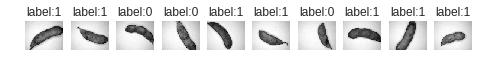

In [2]:
#ダウンロード
!wget "https://github.com/workpiles/soybeans_sorter/raw/master/soybeans_gray.npz" -O soybeans_dataset.npz -q

#ダウンロードしたデータセットの読み込み
IMAGE_HEIGHT = 48
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 1
CLASSES = 2
def load_data():
  data = np.load("soybeans_dataset.npz")
  x_train = data['x_train'].astype('float32') / 255.
  x_test  = data['x_test'].astype('float32') / 255.
  x_train = x_train.reshape([-1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
  x_test  = x_test.reshape([-1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
  y_train = np.eye(CLASSES)[data['y_train']]
  y_test  = np.eye(CLASSES)[data['y_test']]
  return x_train, y_train, x_test, y_test

X_train, y_train, X_test, y_test = load_data()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

#画像の確認
fig, ax = plt.subplots(1, 10)
for i in range(10):
  if IMAGE_CHANNEL == 1:
    ax[i].imshow(X_train[np.random.randint(len(X_train))].reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
  else:
    ax[i].imshow(X_train[np.random.randint(len(X_train))])
  ax[i].axis('off')
  ax[i].set_title("label:%d"%(np.argmax(y_train[i])))
plt.show()

# 畳み込みニューラル・ネットワーク構築
シンプルな5層（*）の畳み込みニューラル・ネットワークです．

*重みを持つ層のみカウント


1.  畳み込み層（ユニット数：32）
2.  Maxプーリング層
3.  畳み込み層（ユニット数：64）
4.  Maxプーリング層
5.  畳み込み層（ユニット数：128）
6.  Maxプーリング層
7.  全結合層（ユニット数：256）
8.  ドロップアウト
9.  全結合層（ユニット数：2）



In [0]:
def build_CNN():
  model_input = Input(shape=[IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNEL])
  x = Conv2D(32, 5, padding='same', activation='relu')(model_input) #48x64x1->48x64x32
  x = MaxPooling2D()(x) #48x64x32->24x32x32
  x = Conv2D(64, 5, padding='same', activation='relu')(x) #24x32x32->24x32x64
  x = MaxPooling2D()(x) #24x32x64->12x16x64
  x = Conv2D(128, 5, padding='same', activation='relu')(x) #12x16x64->12x16x128
  x = MaxPooling2D()(x) #12x16x128->6x8x128
  x = Flatten()(x) #6x8x128->6*8*128
  x = Dense(256, activation='relu')(x) #6*8*128->256
  x = Dropout(rate=0.5)(x)
  model_output = Dense(CLASSES, activation='softmax')(x) #256->1
  
  model = Model(model_input, model_output)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
  return model


# 学習実行

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


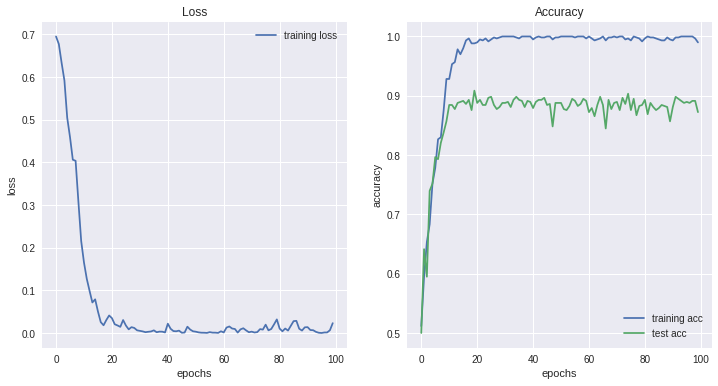

In [4]:
model = build_CNN()

hist = model.fit(X_train, y_train,
                 batch_size = 64,
                 epochs = 100,
                 shuffle=True,
                 validation_data = (X_test, y_test),
                 verbose=0)

#学習経過の表示
fig , ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(hist.history['loss'], label='training loss')
ax[0].set_title("Loss")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].legend()
  
ax[1].plot(hist.history['acc'], label='training acc')
ax[1].plot(hist.history['val_acc'], label='test acc')
ax[1].set_title("Accuracy")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy")
ax[1].legend()

plt.show()

# 学習済みモデルの保存
学習したネットワークの重みやバイアスを保存します．

ここで保存したmodel.h5ファイルを読み込むことで，運用を行う環境で今回学習したニューラル・ネットワークを再構築することができます．

In [0]:
model.save('soybeans_sorter_model.h5')

## ローカルにダウンロード

In [0]:
from google.colab import files

files.download('soybeans_sorter_model.h5')